In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv,MaxPooling
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os

%matplotlib inline

In [2]:
class STL10TrainDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='stl10_train_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


class STL10TestDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='stl10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入
        self.dim_nfeats=len(self.graphs[0].ndata['feat'][0])

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

In [3]:
#transform = transforms.Compose([transforms.Normalize(0,1)])
traindataset=STL10TrainDataset('../data/STL10 Datasets/train/nnum100_ndatades_enone.dgl')
testdataset=STL10TestDataset('../data/STL10 Datasets/test/nnum100_ndatades_enone.dgl')

In [4]:
if os.name =='posix':
    num_workers = 2
else:
    num_workers = 0
num_workers = 0
traindataloader = GraphDataLoader(traindataset,batch_size = 50,shuffle = True,num_workers = num_workers,pin_memory = True)
testdataloader = GraphDataLoader(testdataset,batch_size = 1000,shuffle = True,num_workers = num_workers,pin_memory = True)
print(f'num_wokers = {num_workers}')
print(os.name)

num_wokers = 0
posix


In [20]:
class GCN(nn.Module):
    def __init__(self,in_feat,h_feat,num_classes):
        super(GCN,self).__init__()
        self.gconv1=GraphConv(in_feat,h_feat)
        self.gconv2=GraphConv(h_feat,num_classes)
        self.gconv3=GraphConv(h_feat,num_classes)
        self.dropout=nn.Dropout(0.2)

    def forward(self,g,in_feat):
        h=self.gconv1(g,in_feat)
        h=F.relu(h)
        h=self.dropout(h)
        h=self.gconv2(g,h)
        #h=F.relu(h)
        #h=self.gconv3(g,h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g,'h')

In [45]:
print(traindataset.dim_nfeats)
model=GCN(traindataset.dim_nfeats,320,10)
optimizer=optim.Adam(model.parameters(),lr=0.001)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
epochs=500

61


In [7]:
save_train_acc = []
save_test_acc = []

In [46]:
loss_list = []
acc_list = []
test_acc_list = []


num_correct = 0
num_tests = 0
test_num_correct = 0
test_num_tests = 0
lossF = nn.CrossEntropyLoss()
#,batched_graph.edata['distance'].float()
BP = 0
for epoch in tqdm(range(epochs)):
    if BP != 0:
        break
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'].float())
        loss = lossF(pred,labels)
        if loss.item() < 0.05:
            BP = 0
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    loss_list.append(loss.item())
    acc_list.append(num_correct / num_tests) #学習中トレーニングacc
    
    model.eval()
    for tbatched_graph, tlabels in testdataloader:
        tbatched_graph = tbatched_graph.to(device)
        tlabels = tlabels.to(device)
        tpred = model(tbatched_graph, tbatched_graph.ndata['feat'])
        test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
        test_num_tests += len(tlabels)

    Tacc = test_num_correct / test_num_tests
    #print('Training accuracy:', Tacc)
    test_acc_list.append(Tacc) #学習中テストacc


100%|██████████| 500/500 [17:04<00:00,  2.05s/it]


In [47]:
num_correct = 0
num_tests = 0



with torch.no_grad():
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'])
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Training accuracy:', num_correct / num_tests)
    save_train_acc.append(num_correct / num_tests)
    num_correct = 0
    num_tests = 0
    model.eval()
    for batched_graph, labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Test accuracy:', num_correct / num_tests)
    save_test_acc.append(num_correct / num_tests)

Training accuracy: 0.3044
Test accuracy: 0.2725681420355089


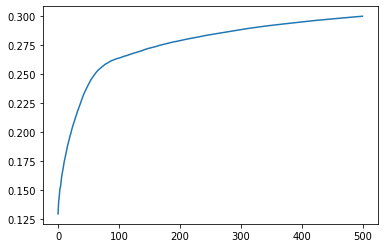

In [48]:
x=[i for i in range(len(acc_list))]
y=acc_list
plt.plot(x,y)
plt.show()

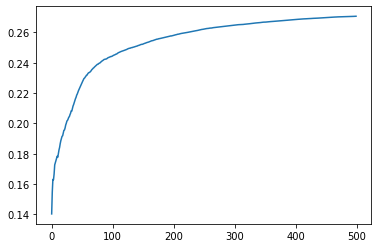

In [49]:
plt.plot(x,test_acc_list)

plt.show()

In [65]:
print(save_test_acc)

[0.24256064016004, 0.1000250062515629, 0.2639409852463116, 0.27019254813703425, 0.27019254813703425, 0.2604401100275069, 0.2248062015503876, 0.20392598149537383, 0.23605901475368843, 0.2455613903475869]
